# Wykrywanie anomalii sieciowy

## 3 Sieci neuronowe (nn)

- Nieliniowości w modelu
- Przeuczenie
- Regularyzacja

## Plan

- Wprowadzenie 15 min
- nn 20 min
- Przeuczenie 20 min
- Regularyzacja 25 min
- Podsumowanie 10 min


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import functools as ft
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

# Uniwersalny aproksymator

Wygenerujmy funkcję

c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


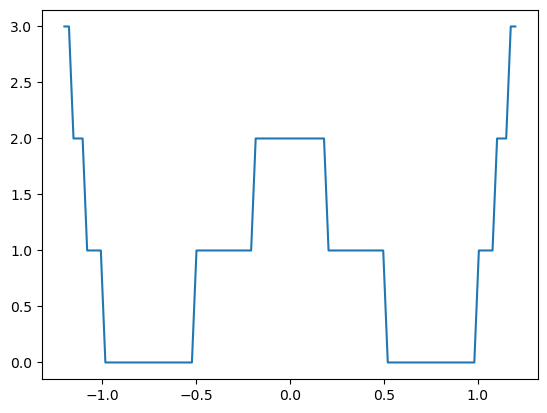

In [2]:
def star_caise_function(x):
    p=jnp.poly(-jnp.array([-1,-0.5,0.5,1]))
    smooth = jnp.polyval(p,x)/0.2
    return jnp.ceil(smooth),smooth

x = np.linspace(-1.2,1.2,100)
y,ysmooth = star_caise_function(x)

sns.lineplot(x=x,y=y)
plt.show()

In [3]:

def init_nn(key,shapes):
    params = [ dict(
        w=0.1*jax.random.normal(key,shape),
        b=jnp.zeros(shape[-1]),
    ) for shape in shapes]
    return params

@jax.jit
def apply_nn(theta:dict,x:jnp.ndarray):
    for i,layer in enumerate(theta):
        if i != len(layer)-1:
            x = jax.nn.tanh(x@layer['w'] + layer['b'])
        else:
            x = x@layer['w'] + layer['b']
    return x

@jax.jit
def mse(params,x,y):
    nn_out = apply_nn(params,x)
    return jnp.mean(jnp.square(y-nn_out))

In [4]:
np.random.seed(42)
xtrain = np.random.uniform(low=x[0],high=x[-1],size=(256,1))
ytrain,_ = star_caise_function(xtrain)


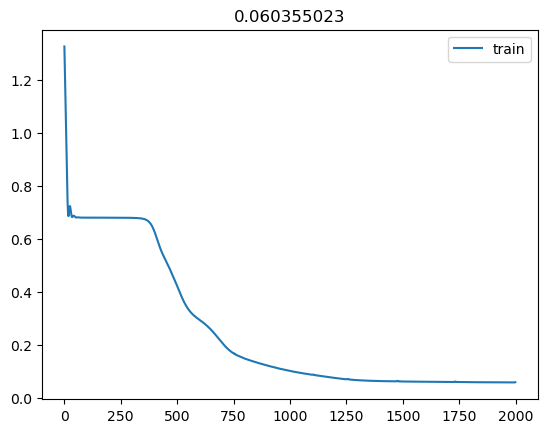

In [5]:
k = jax.random.PRNGKey(42)

params  = init_nn(k,[(xtrain.shape[1],16),(16,ytrain.shape[1])])
losses=[]

grad_loss = jax.jit(jax.grad(mse))

opt_init, opt_update, get_params = adam(0.01)
opt_state = opt_init(params)

for i in range(2000):
    grads = grad_loss(params,xtrain,ytrain)
    opt_state = opt_update(i, grads, opt_state)
    params = get_params(opt_state)
    losses.append(mse(params,xtrain,ytrain))

plt.plot(losses,label='train')
plt.title(str(losses[-1]))
plt.legend()



Zobaczmy jak wygląda dopasowanie i przy okazji pochodna

c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn

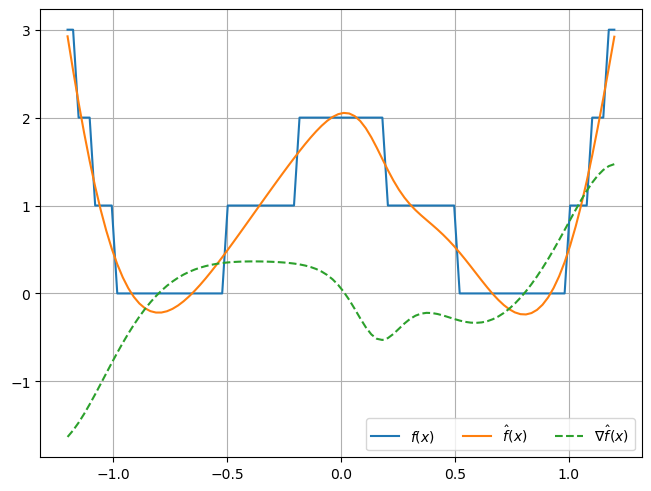

In [6]:
@jax.jit
def grad_fn(params, x):
    @ft.partial(jax.vmap, in_axes=(0, None))
    @jax.grad
    def fn(x, params):
        return apply_nn(params, jnp.expand_dims(x, 0))[0,0]

    return fn(x, params)


yhat = apply_nn(params,x[..., np.newaxis])
grads = grad_fn(params,x[..., np.newaxis])

fig, ax = plt.subplots( constrained_layout=True)

sns.lineplot(x=x, y=y, label='$f(x)$', ax=ax)
sns.lineplot(x=x, y=yhat[:,0], label='$\hat f(x)$', ax=ax)
ax = sns.lineplot(x=x, y=0.1 * grads[:,0], label=r'$\nabla \hat f(x)$', ax=ax)
ax.lines[2].set_linestyle("--")
plt.legend(ncol=3)
plt.grid(True)
plt.show()


# Mini biblioteka

Strukture sieci mozna kodować w naszym wzorcu funkcyjnym `init` i `update`jednak w miare dodawania mechanizmów implementacja się komplikuje.

JAX dostarcza bardzo prostą bibliotekę `stax` która działa dokładnie jak nasze proste modele a pokazuje tez uniwersalne API w bibliotekach do uczenia maszynowego.
Poniżej sprawdzimy jak wygląda api w `stax` i rozbudujemy je o kilka przydanych funkcji.

Najwazniejsza funckjonaość `stax` to kombinarory pozwalające łączyć moduły
```python
nn = stax.serial(
    stax.Dense(16),
    stax.Tanh,
    stax.Dense(1)
)
```

In [7]:
@jax.jit
def mse(y,yhat):
    #nn_out = apply_nn(params,x)
    return jnp.mean(jnp.square(y-yhat))

@jax.jit
def cross_entropy(y,logits):
    #nn_out = apply_nn(params,x)
    lp = jax.nn.log_softmax(logits)
    return -jnp.mean(lp*y)



@ft.partial(jax.jit, static_argnames=('n'))
def confusion_matrix(labels, predictions, n):
    '''
    :param labels: Prawdziwe etykiety
    :param predictions: Przeidywane etykiety
    :param n: liczba różnych etykiet
    :return: macierz pomyłek, w wierszach prawdziwe etykiety, w kolumnie predykcje
    '''
    cm, _ = jax.lax.scan(
        lambda carry, pair: (carry.at[pair].add(1), None),
        jnp.zeros((n,n), dtype=jnp.uint32),
        (labels, predictions)
        )
    return cm

@jax.jit
def classification_summary(cm):
    return dict(
        acc=jnp.sum(jnp.diag(cm))/jnp.sum(cm),
        tpr=jnp.diag(cm)/jnp.sum(cm, axis=1),
        ppv=jnp.diag(cm)/jnp.sum(cm, axis=0)
    )

## test działania

In [8]:
k = jax.random.PRNGKey(43)

d = stax.Dense(4)
print(d)

init,apply = d
_,params = init(k,(4,3))
x = np.random.normal(size=(8,3))
apply(params,x )


(<function Dense.<locals>.init_fun at 0x00000174E21DC670>, <function Dense.<locals>.apply_fun at 0x00000174BB0C43A0>)


Array([[-0.07110156,  0.07300892, -0.02990044, -0.29552162],
       [-0.14411348, -0.01644426, -0.37782145,  0.06025977],
       [-0.05995309,  0.5680605 ,  0.74184036, -1.1240366 ],
       [-1.0259044 ,  0.7576314 , -1.6598871 ,  0.26218775],
       [-0.19510972,  0.63130033,  0.47662058, -1.1067029 ],
       [-2.2590108 ,  3.9937727 ,  0.01565078, -4.778653  ],
       [-0.4780556 ,  0.94784427,  0.21032621, -1.4695444 ],
       [-0.6723848 ,  0.63322484, -0.8697819 , -0.10721435]],      dtype=float32)

# Diamenty

Dalej pracujemy na danych o diamentach

In [9]:
diamonds = pd.read_csv('../data/diamonds.csv')

diamonds = diamonds.sample(frac=1)

clarity = pd.get_dummies(diamonds['clarity'])
color = pd.get_dummies(diamonds['color'])
diamonds.drop(['color' , 'clarity'] , axis = 1 , inplace=True)

x = diamonds.drop(['cut'], axis = 1 ).to_numpy()
y = pd.get_dummies(diamonds.cut).to_numpy()

x=(x-np.mean(x,0))/np.std(x,0)
x=jnp.concatenate([x,color.to_numpy(), clarity.to_numpy()], axis=1)

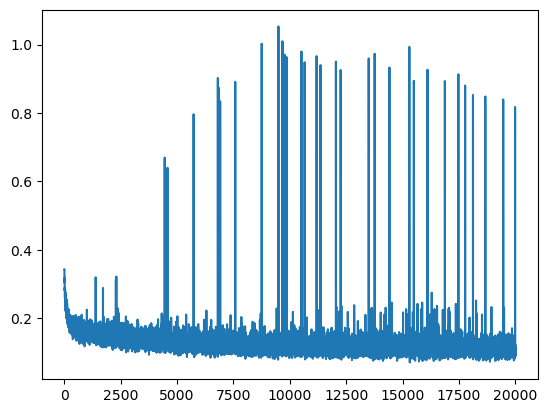

In [10]:
batch_size=128
steps=20000
learning_rate=0.001

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]

for i in range(steps):
    idx = np.random.randint(0,x.shape[0],size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)
    losses.append(step_loss)

plt.plot(losses)

{'acc': Array(0.7800519, dtype=float32), 'ppv': Array([0.8957055 , 0.71561164, 0.8236596 , 0.8101744 , 0.6515195 ],      dtype=float32), 'tpr': Array([0.81614906, 0.61292297, 0.91527075, 0.80835325, 0.5696077 ],      dtype=float32)}


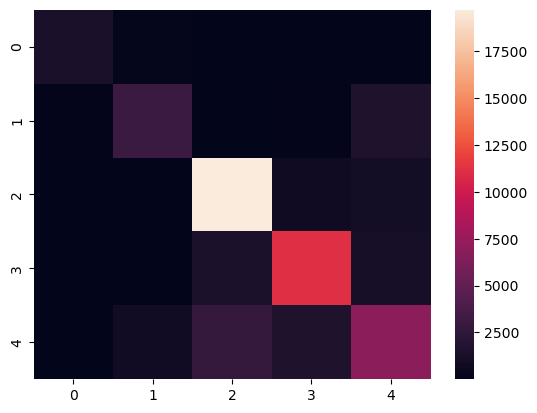

In [11]:
c = apply_nn(get_params(opt_state), x)
c = jnp.argmax(c, 1)

cm=confusion_matrix(jnp.argmax(y,1),c,5)
sns.heatmap(cm, label=True)
print(classification_summary(cm))

# Walidacja

## Zadanie

Przetestować model na nowych danych

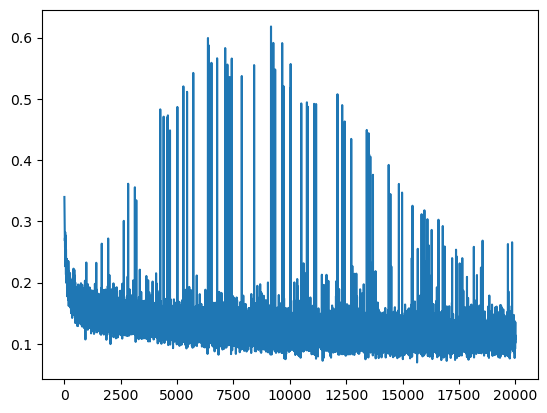

In [12]:
#TODO

batch_size=128
steps=20000
learning_rate=0.001
train_split=int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]

@jax.jit
def test_loss(opt_state, x, y):
   params = get_params(opt_state)
   logits = apply_nn(params, x)
   return cross_entropy(y, logits)

for i in range(steps):
    idx = np.random.randint(0, train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)
    losses.append(step_loss)

    tx=x[train_split:, ...]
    ty=y[train_split:, ...]

    test_losses.append(test_loss(opt_state, tx, ty))

plt.plot(losses)

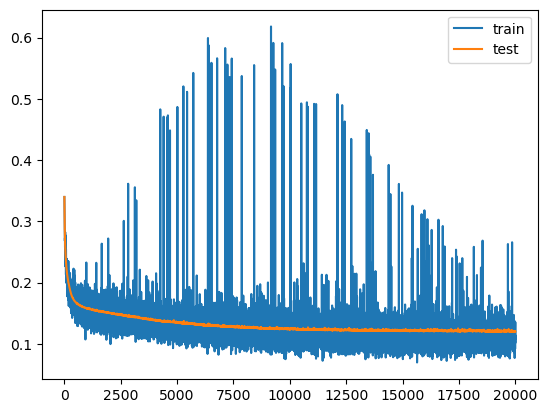

In [13]:
plt.plot(losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

# Przeuczenie

Przeuczenie występuje, gdy mdoel dziła gorzej na nowych danych niż na danych treningowych.
Najczęściej wynika z małej liczby danych.

## Zadanie

Zmniejszyć zbiór treningowy do kilkuset przykładów

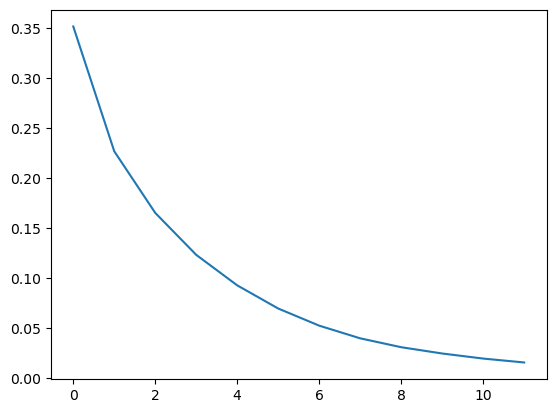

In [34]:
#TODO
batch_size=32
steps=600
learning_rate=0.001
train_split=int(0.001*x.shape[0])

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]
train_steps=[]

@jax.jit
def test_loss(opt_state, x, y):
   params = get_params(opt_state)
   logits = apply_nn(params, x)
   return cross_entropy(y, logits)

for i in range(steps):
    idx = np.random.randint(0, train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)
    # losses.append(step_loss)

    # tx=x[train_split:, ...]
    # ty=y[train_split:, ...]

    # test_losses.append(test_loss(opt_state, tx, ty))
    if i % 50 == 0:
        tx=x[train_split:, ...]
        ty=y[train_split:, ...]
        test_losses.append(test_loss(opt_state, tx,ty))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split],y[:train_split]))

plt.plot(losses)

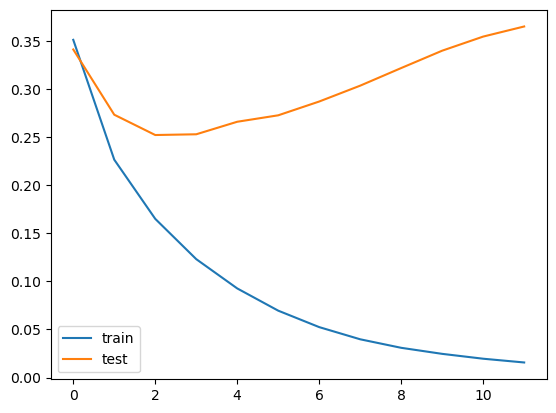

In [35]:
plt.plot(losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

# Regularyzacja

## Zadanie

Przeuczenie ograniczamy regularyzując model.
Zmodyfikować funkcje ksoztu tak aby zawierała czynnik proporcjonalny do $\sum_{ijk}w_{ijk}^2$

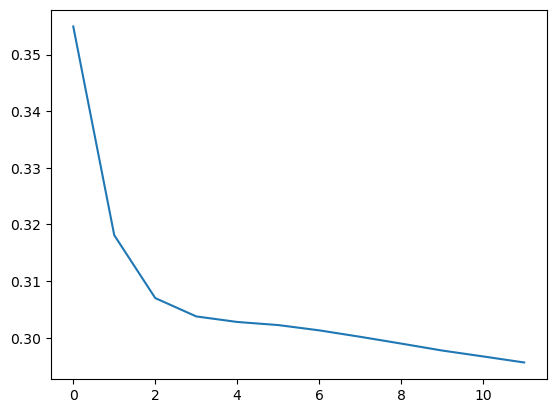

In [37]:
#TODO
batch_size=128
steps=600
learning_rate=0.001
train_split=int(0.001*x.shape[0])

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      ce = cross_entropy(y, logits)
      l2 = sum([0.8*jnp.sum(jnp.square(layer[0])) for layer in params if len(layer)>0])
      return ce + l2

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]
train_steps=[]

@jax.jit
def test_loss(opt_state, x, y):
   params = get_params(opt_state)
   logits = apply_nn(params, x)
   return cross_entropy(y, logits)

for i in range(steps):
    idx = np.random.randint(0, train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)

    if i % 50 == 0:
        tx=x[train_split:, ...]
        ty=y[train_split:, ...]
        test_losses.append(test_loss(opt_state, tx,ty))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split],y[:train_split]))

plt.plot(losses)

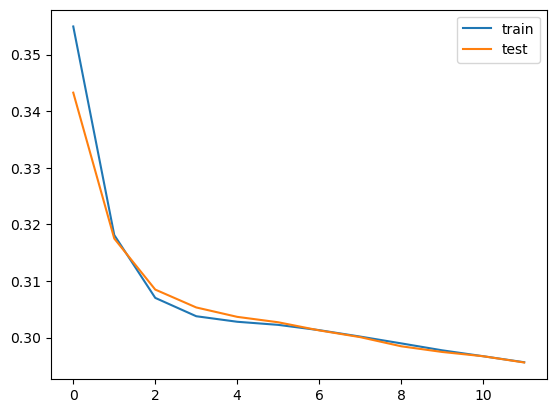

In [38]:
plt.plot(losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

# Bonus: macierz pomyłek

Macierz pomyłek zawiera zliczenie według prawdziwej przewidywanej klasy.
W implementacji dostarczonej w tym notatniku każdy wiersz odpowiada jednej klasie w danych.
Każda kolumna to jedna klasa przewidziana przez model.
Przekątna zawiera poprawne klasyfikacje.

[Tablica pomyłek](https://pl.wikipedia.org/wiki/Tablica_pomyłek)

<Axes: >

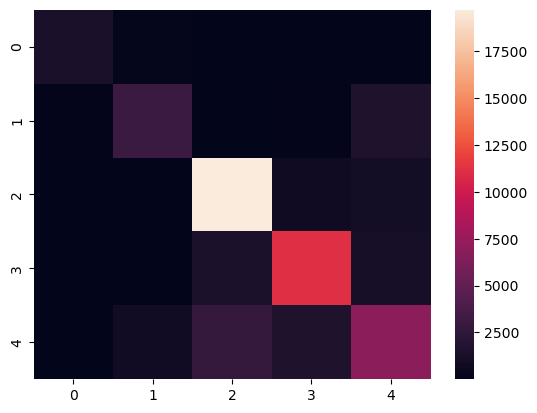

In [39]:
sns.heatmap(cm)

#### Dokładność

In [40]:
np.sum(np.diag(cm))/np.sum(cm)

Array(0.7800519, dtype=float32)

#### Czułość

Jaka część klazdej klasy została poprawnie przewidziana


In [41]:
np.diag(cm)/np.sum(cm, axis=1)

Array([0.81614906, 0.61292297, 0.91527075, 0.80835325, 0.5696077 ],      dtype=float32)

#### Precyzja

Jaka z predykcji danej klasy była poprawna

In [42]:
np.diag(cm)/np.sum(cm, axis=0)

Array([0.8957055 , 0.71561164, 0.8236596 , 0.8101744 , 0.6515195 ],      dtype=float32)